# Setup

In [224]:
# %pip install -q -r requirements.txt

In [225]:
from dotenv import load_dotenv
load_dotenv()

True

## LLM and Embedding

In [226]:
import os
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

# TODO: Add Ollama alternative

############### Init LLM ###############
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
)

############### Init embeddings ###############
embeddings = AzureOpenAIEmbeddings(model=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT_NAME"))

# Persistent database

In [227]:
import sqlite3
chat_db_path = "db/chats/example.db"
student_db_path = "db/students/students.db"

conn = sqlite3.connect(chat_db_path, check_same_thread=False)

In [228]:
from langgraph.checkpoint.sqlite import SqliteSaver
persistent_memory = SqliteSaver(conn)

## State

In [229]:
from typing import Optional, List, Annotated
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState
import operator

# Student class
class Student(BaseModel):
    ''' Class for agent to fill out, which fits with SQL table '''
    
    username: str = Field(description='The username for the student, which is a unique identifier')
    name: Optional[str] = Field(None, description='Name of student')
    summary: Optional[str] = Field(None, description='A summary of the students profile, based on available fields')
    @property
    def persona(self) -> str:
        return f"Username:\n {self.username}\n Name:\n {self.name}\nSummary\n {self.summary}"

# Graph state
class StudyAgentState(MessagesState):
    username: str
    student: Optional[Student]
    new_profiling_info: str
    session_docs: List[str]
    documents: Annotated[List[str], operator.add]

# Student

## Load

In [230]:
def fetch_student_profile(username: str) -> Student:
    ''' Retrieve student profile if existing '''
    
    # Connect to the SQLite database (adjust the path to your database file)
    connection = sqlite3.connect(student_db_path)
    cursor = connection.cursor()

    # Execute the query to search for the student by username
    cursor.execute('SELECT * FROM students WHERE username = ?', (username,))

    # Fetch the result
    student_data = cursor.fetchone()

    # Close the connection
    cursor.close()
    connection.close()

    # If a student is found, return a Student object, otherwise return None
    if student_data:
        _, username, name, summary = student_data
        return Student(username=username, name=name, summary=summary)
    else:
        return Student(username=username)
    
def load_student(state: StudyAgentState) -> StudyAgentState:
    ''' Loading user from SQL based on username, if it exists '''
    print('--- Loading Student ---')
    username = state['username']
    student = fetch_student_profile(username)
    
    return {'student': student}

## Update

In [231]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage

# SQL function for updating db
def update_db(student: Student) -> None:
    ''' Update student profile if existing '''
    print('--- Updating DB ---')
    # Connect to the SQLite database (adjust the path to your database file)
    connection = sqlite3.connect(student_db_path)
    cursor = connection.cursor()

    # Execute the query to upsert the student
    cursor.execute(
        '''
        INSERT INTO students (username, name, summary)
        VALUES (:username, :name, :summary)
        ON CONFLICT(username) 
        DO UPDATE SET 
            name = excluded.name,
            summary = excluded.summary;
        ''', 
        {
            'username': student.username,
            'name': student.name,
            'summary': student.summary
        }
    )

    # Commit the transaction to save the changes
    connection.commit()

    # Close the connection
    cursor.close()
    connection.close()

    print('DB updated')


# Node for updating student profile and db
update_student_prompt = ''' 
You are tasked with updating the profile of the following student. The student's current profile will be provided below. Review the profile and update any missing or incomplete fields, including the student's name and summary.

- If the student's name is missing or incorrect, suggest an appropriate name or confirm the correct name if possible.
- If the summary is incomplete, add relevant details to provide a more complete profile of the student's academic background or learning habits.
- Do not modify the username, as it is a unique identifier.

Here is the student's current profile:
Username: {student_username}
Name: {student_name}
Summary: {student_summary}

Here is what was extracted from the agent:
{extracted_info}

Please provide the updated profile with all relevant fields filled in. If a field is already complete, leave it unchanged.
'''

def update_student_profile(state: StudyAgentState):
    """ Node for updating the student profile """
    print('--- Updating student ---')
    student = state['student']
    messages = state['messages']
    last_message = messages[-1]

    # Check if <student_profiling> tag exists in the last message content
    if "student_profiling>" in last_message.content:
        clean_message = last_message.content.split("<student_profiling>")[0] + last_message.content.split("</student_profiling>")[1].strip()
    else:
        clean_message = last_message.content

    extracted_info = last_message.content.split("student_profiling>")[1].split("</")[0].strip()

    formatted_prompt = update_student_prompt.format(
        student_username=student.username,
        student_name=student.name if student.name else "Not Provided",
        student_summary=student.summary if student.summary else "Not Provided",
        extracted_info=extracted_info
    )

    structured_llm = llm.with_structured_output(Student)
    updated_student = structured_llm.invoke(
        [SystemMessage(content=formatted_prompt)] + 
        [HumanMessage(content=f'Student to update: \n {student.persona}')] +
        messages
    )

    print(f'Student before: \n {student}')
    print(f'Updated student: \n {updated_student}')
    
    update_done_msg = AIMessage(clean_message)
    
    update_db(updated_student)

    print(f'Message: \n {clean_message}')
    print('--- END ---')
    return {'student': updated_student, 'messages': [RemoveMessage(id=last_message.id)] + [update_done_msg]}

# Extract student info

In [232]:
profiling_prompt = '''
You are an intelligent student profiling assistant responsible for analyzing student queries to determine if new 
information is available for updating the student profile. Your task is not to respond directly to the user 
but to route the query based on whether new student data is present.

Information you should look for includes:

    Name
    Topic or subject being studied
    Academic profile (e.g., courses, level of study)
    Learning goals (e.g., objectives or future targets)
    Preferences (e.g., study methods, preferred learning materials)

If the query provides new student data, return: <student_profiling>[extracted information]</student_profiling>

If there is no new data to update, return: No new user data

This node does not interact with the user directly but ensures that any new student information is properly 
flagged for future updates.

Here is what we know about the student so far:
{student_persona}
'''

# This node sets the new_profiling_info state
# It could be changed into a route, if it didn't have to set stage
def extract_profiling_info(state: StudyAgentState):
    ''' Node/Route for whether to update student profile or not '''
    print('--- Extract student info ---')
    student = state['student']
    latest_message = state['messages'][-1]

    formatted_prompt = profiling_prompt.format(student_persona = student.persona)
    route = llm.invoke([SystemMessage(content=formatted_prompt)] + [latest_message])

    if '<student_profiling>' in route.content:
        print('Updated new profiling info in state')
        return {'new_profiling_info': route.content}
    else:
        print('No further profiling data')

# Update student profile

In [233]:
def update_db(student: Student) -> None:
    ''' Update student profile if existing '''
    print('--- Updating DB ---')
    # Connect to the SQLite database (adjust the path to your database file)
    connection = sqlite3.connect(student_db_path)
    cursor = connection.cursor()

    # Execute the query to upsert the student
    cursor.execute(
        '''
        INSERT INTO students (username, name, summary)
        VALUES (:username, :name, :summary)
        ON CONFLICT(username) 
        DO UPDATE SET 
            name = excluded.name,
            summary = excluded.summary;
        ''', 
        {
            'username': student.username,
            'name': student.name,
            'summary': student.summary
        }
    )

    # Commit the transaction to save the changes
    connection.commit()

    # Close the connection
    cursor.close()
    connection.close()

    print('DB updated')

In [234]:
update_student_prompt = ''' 
You are tasked with updating the profile of the following student. The student's current profile will be provided below. Review the profile and update any missing or incomplete fields, including the student's name and summary.

- If the student's name is missing or incorrect, suggest an appropriate name or confirm the correct name if possible.
- If the summary is incomplete, add relevant details to provide a more complete profile of the student's academic background or learning habits.
- Do not modify the username, as it is a unique identifier.

Here is the student's current profile:
Username: {student_username}
Name: {student_name}
Summary: {student_summary}

Here is what was extracted from the agent:
{extracted_info}

Please provide the updated profile with all relevant fields filled in. If a field is already complete, leave it unchanged.
'''

def update_profile(state: StudyAgentState):
    """ Node for updating the student profile """
    print('--- Updating student ---')
    student = state['student']
    messages = state['messages']
    extracted_info = state['new_profiling_info']

    formatted_prompt = update_student_prompt.format(
        student_username=student.username,
        student_name=student.name if student.name else "Not Provided",
        student_summary=student.summary if student.summary else "Not Provided",
        extracted_info=extracted_info
    )

    structured_llm = llm.with_structured_output(Student)
    updated_student = structured_llm.invoke(
        [SystemMessage(content=formatted_prompt)] + 
        [HumanMessage(content=f'Student to update: \n {student.persona}')] +
        messages
    )

    print(f'Student before: \n {student}')
    print(f'Updated student: \n {updated_student}')
    
    update_db(updated_student)

    return {'student': updated_student, 'new_profiling_info': ''}

# Retrievers

In [235]:
def dummy_retriever(state: StudyAgentState):
    ''' Node before deciding which retriever to use'''
    pass

In [236]:
from langchain_chroma import Chroma
from langchain.vectorstores import DocArrayInMemorySearch

def retrieve_docs_chroma(state: StudyAgentState):
    ''' Retriever for getting context and docs '''
    print('--- Chroma Retriever ---')
    query = state["messages"][-1].content
    
    embeddings = AzureOpenAIEmbeddings(model=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT_NAME"))
    current_dir = os.path.dirname(os.path.abspath("full_development.ipynb"))
    db_dir = os.path.join(current_dir, "db")
    persistent_directory = os.path.join(db_dir, "test_material")
    db = Chroma(
        persist_directory=persistent_directory,
        embedding_function=embeddings
    )
    retriever = db.as_retriever()
    docs = retriever.invoke(query)

    return {'documents': docs}

def retrieve_docs_inmemory(state: StudyAgentState):
    ''' Retriever for getting context and docs '''
    print('--- InMemory Retriever ---')
    query = state["messages"][-1].content
    documents = state.get('session_docs', [])

    if len(documents) > 0:
        embeddings = AzureOpenAIEmbeddings(model=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT_NAME"))
        retriever = DocArrayInMemorySearch.from_documents(documents, embeddings)

        docs = retriever.similarity_search(query, k=3)

        return {'documents': docs}

# Document grader

In [244]:
# First is the retrieval grader, which takes a documents content and evaluates whether it is useful or not
# The grader is a simple chain, with a prompt and an llm
# It is later used in a node, to go through retrieved documents
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

# Structured output class - Either useful or useless
class DocumentGrade(BaseModel):
    document_grade: str = Field(description="Grading of retrieved document, 'useful' or 'useless'")

# Prompt template for the llm to evaluate documents
grader_instruction = """
You are tasked with determining whether a document is relevant to a student's inquiry.
Evaluate the document based on its ability to directly address or provide useful information regarding the question or topic posed by the student.
If the document is relevant and contains valuable information, respond with 'useful'.
If the document is unrelated or does not contribute meaningfully to the inquiry, respond with 'useless'.
Be objective and concise in your evaluation.
"""
grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_instruction),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# LLM with class as output, string of either useful or useless
grader_llm = llm.with_structured_output(DocumentGrade)

# Grader chain
doc_grader = grader_prompt | grader_llm

def grade_docs(state: StudyAgentState):
    ''' Grader to filter retrieved documents by relevance '''
    print('--- Doc Grader ---')
    question = state['messages'][-1].content
    documents = state.get('documents', [])
    filtered_docs = []
    
    if len(documents) > 0:
        for doc in documents:
            usefulness = doc_grader.invoke({'document': doc, 'question': question})
            if usefulness.document_grade == 'useful':
                filtered_docs.append(doc)
            elif usefulness.document_grade == 'useless':
                continue

    return {'documents': filtered_docs}

# Teacher

In [251]:
# teacher_instructions = """
#     You are an experienced and patient teacher helping students learn 
#     by answering their questions. Your goal is to not only provide 
#     the correct answers but also to explain concepts clearly and thoroughly, 
#     breaking them down into smaller steps when necessary. Provide 
#     examples where appropriate, encourage critical thinking by asking 
#     follow-up questions, and make sure the student feels supported in 
#     their learning journey. Aim to foster a deeper understanding 
#     rather than just memorization. If the student seems confused, 
#     gently guide them through the problem with hints or re-explanations.

    # You should take the following documents into consideration
    # and cite them if used:
    # {documents}
#     """

teacher_instructions = ''' 
You are an experienced and patient teacher helping students learn by answering their questions. Your goal is to not 
only provide correct answers but also explain concepts clearly and thoroughly, breaking them down into smaller steps 
when necessary. Use the student's profile to personalize your responses. This is the students profile so far:
    
{student_profile}

Before answering the student’s question, check their profile to see what information is already known, such as their 
name and summary. Use this information to tailor your response. If you notice key details like their name or learning 
goals are missing, answer their question first, then follow up with a polite inquiry to gather the missing information. 
Avoid asking for details already recorded.

For example:
    If the name is missing, you could ask: 'By the way, could you share your name so I can address you more personally 
    in the future?'
    If the learning goals are unclear, ask: 'Could you tell me about your learning goals so I can assist you more 
    effectively?'

Provide examples where appropriate, encourage critical thinking, and ensure the student feels supported. If they seem 
confused, guide them with hints or re-explanations, always fostering deeper understanding rather than memorization.
'''

def answering_teacher(state: StudyAgentState):
    ''' Teacher node to answer student '''
    print('--- Teacher ---')
    messages = state['messages'] # Contains student question
    student = state['student']
    documents = state['documents']

    sys_msg = teacher_instructions.format(student_profile = student.persona)

    if len(documents) > 0:
        context = f'''
        You should take the following documents into consideration
        and cite them if used:
        {documents}
        
        You should cite them with a number, e.g. [1] and end with a "Sources" which contains the sources cited
        '''
        sys_msg += f'\n {context}'

    answer = llm.invoke([SystemMessage(content=sys_msg)] + messages) # Answers student question

    return {'messages': answer} # Adds answer to messages

# Edges

In [239]:
from typing import Literal

# Check student state
def student_exist_route(state: StudyAgentState) -> Literal['load_student', 'extract_profiling_info']:
    ''' Router to load user if profile not in state '''
    print('--- Student exist route ---')
    student = state.get('student', None)

    # If the student doesn't exist, a node for loading or creating student is used
    if student is None:
        return 'load_student'
    
    return 'extract_profiling_info'

In [240]:
def update_student_route(state: StudyAgentState):
    ''' Route for deciding whether to update student profile or just answer questions '''
    print('--- New student info route ---')
    new_profiling_info = state.get('new_profiling_info', '')

    if new_profiling_info:
        print(new_profiling_info)
        return 'update_profile'
    else:
        print('No new info')
        return 'retriever'

# Graph

In [241]:
def status(state: StudyAgentState):
    print('--- Status ---')
    print(f'Student: {state['student']}')
    print(f'Messages: \n')
    for message in state['messages']:
        message.pretty_print()

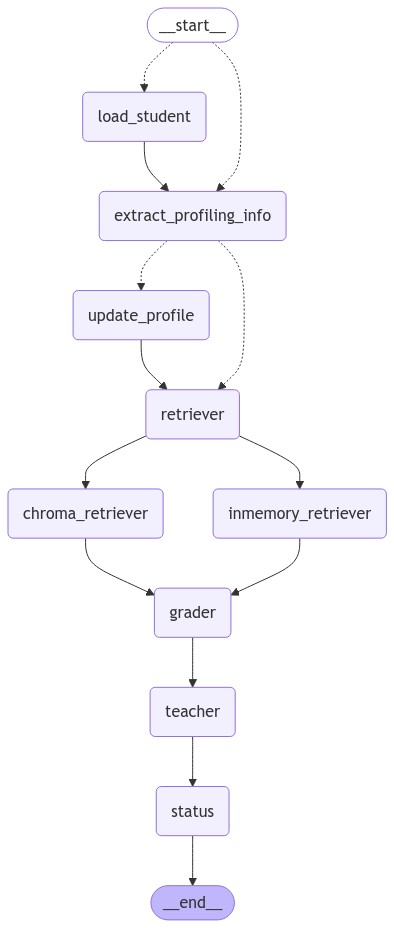

In [252]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

studyagent_workflow = StateGraph(StudyAgentState)

# Student profiling
studyagent_workflow.add_node('load_student', load_student)
studyagent_workflow.add_node('extract_profiling_info', extract_profiling_info)
studyagent_workflow.add_node('update_profile', update_profile)

# Retrieve documents
studyagent_workflow.add_node('retriever', dummy_retriever)
studyagent_workflow.add_node('chroma_retriever', retrieve_docs_chroma)
studyagent_workflow.add_node('inmemory_retriever', retrieve_docs_inmemory)
studyagent_workflow.add_node('grader', grade_docs)

# Create answer
studyagent_workflow.add_node('teacher', answering_teacher)
studyagent_workflow.add_node('status', status)

# Edges
studyagent_workflow.add_conditional_edges(START, student_exist_route, ['load_student', 'extract_profiling_info'])
studyagent_workflow.add_edge('load_student', 'extract_profiling_info')
studyagent_workflow.add_conditional_edges('extract_profiling_info', update_student_route, ['update_profile', 'retriever'])

studyagent_workflow.add_edge('update_profile', 'retriever')
studyagent_workflow.add_edge('retriever', 'inmemory_retriever')
studyagent_workflow.add_edge('retriever', 'chroma_retriever')
studyagent_workflow.add_edge('inmemory_retriever', 'grader')
studyagent_workflow.add_edge('chroma_retriever', 'grader')
studyagent_workflow.add_edge('grader', 'teacher')
studyagent_workflow.add_edge('teacher', 'status')
studyagent_workflow.add_edge('status', END)

memory = MemorySaver()
studyagent_graph = studyagent_workflow.compile(checkpointer=persistent_memory)

display(Image(studyagent_graph.get_graph().draw_mermaid_png()))

# Test graph

In [253]:
username = 'Allllaaan'
student_q = 'What features are used for sound detection?'
config = {'configurable': {'thread_id': username}}
ses_docs = []

answer_state = studyagent_graph.invoke({'username': username, 'messages': [HumanMessage(content=student_q)], 'session_docs': ses_docs}, config)

--- Student exist route ---
--- Loading Student ---
--- Extract student info ---
No further profiling data
--- New student info route ---
No new info
--- Chroma Retriever ---
--- InMemory Retriever ---
--- Doc Grader ---
--- Teacher ---
--- Status ---
Student: username='Allllaaan' name=None summary=None
Messages: 

================================ Human Message =================================

What features are used for sound detection?
================================== Ai Message ==================================

Sound detection involves analyzing various features of the sound. Two key characteristics used in sound detection are frequency and amplitude [1]. 

Frequency refers to the pitch of the sound, which is how high or low it sounds. It is determined by the speed of the sound wave's vibration. On the other hand, amplitude refers to the loudness or intensity of the sound, which is determined by the height of the sound wave.

A tool called a spectrogram is often used to visuali

In [254]:
answer_state

{'messages': [HumanMessage(content='What features are used for sound detection?', additional_kwargs={}, response_metadata={}, id='1d5cded2-1142-4c6b-8260-ac7a1997eaca'),
  AIMessage(content="Sound detection involves analyzing various features of the sound. Two key characteristics used in sound detection are frequency and amplitude [1]. \n\nFrequency refers to the pitch of the sound, which is how high or low it sounds. It is determined by the speed of the sound wave's vibration. On the other hand, amplitude refers to the loudness or intensity of the sound, which is determined by the height of the sound wave.\n\nA tool called a spectrogram is often used to visualize these features in a sound [1]. It shows which frequencies are present in the sound at any given time, thus making it possible to identify when an event starts and stops, register what's happening in the event, or even assess the quality of the event. This can be particularly useful in fields such as healthcare, where the qual

In [255]:
new_query = 'My name is Kasper and I study applied Machine learning. I have an exam on deep learning in 4 weeks. How can i study for it?'

answer_state = studyagent_graph.invoke({'messages': [HumanMessage(content=new_query)]}, config)

--- Student exist route ---
--- Extract student info ---
Updated new profiling info in state
--- New student info route ---
<student_profiling>Name: Kasper, Topic being studied: Applied Machine Learning, Specific subject: Deep Learning, Future target: Exam in 4 weeks</student_profiling>
--- Updating student ---
Student before: 
 username='Allllaaan' name=None summary=None
Updated student: 
 username='Allllaaan' name='Kasper' summary='Kasper is a diligent student studying Applied Machine Learning, with a focus on Deep Learning. He is preparing for an exam in 4 weeks and is dedicated to achieving the best possible results.'
--- Updating DB ---
DB updated
--- Chroma Retriever ---
--- InMemory Retriever ---
--- Doc Grader ---
--- Teacher ---
--- Status ---
Student: username='Allllaaan' name='Kasper' summary='Kasper is a diligent student studying Applied Machine Learning, with a focus on Deep Learning. He is preparing for an exam in 4 weeks and is dedicated to achieving the best possible re